### Define Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://raw.githubusercontent.com/nand-desai/Data-607-Project/main/data_train.csv", index_col=0)

In [2]:
#Overview of the top 'n' genres and the proportion of songs within each cluster of the training df
n = 5

song_count = len(df)
genre_dict = {cluster: list(df['track_genre'][df['cluster'] == cluster].value_counts().index[:n]) for cluster in df['cluster'].unique()}
cluster_df = pd.DataFrame({"cluster":df['cluster'], "genre": df['track_genre']})
count_dict_unformatted = cluster_df['cluster'].value_counts().to_dict()
count_dict = pd.DataFrame({k: [f"{v/song_count*100:.0f}%"] for k,v in count_dict_unformatted.items()})

summary_df = pd.concat([pd.DataFrame(genre_dict), pd.DataFrame(count_dict)], ignore_index = True)
summary_df.rename({i: i+1 for i in range(len(summary_df))}).rename({len(summary_df): "Percent of Data"})

,1,2,4,0,7,3,5,6
1,tango,kids,comedy,pagode,k-pop,metalcore,new-age,minimal-techno
2,romance,latin,show-tunes,samba,pop-film,heavy-metal,classical,detroit-techno
3,honky-tonk,party,funk,sertanejo,forro,death-metal,sleep,techno
4,cantopop,salsa,kids,mpb,deep-house,hardstyle,ambient,chicago-house
5,jazz,reggae,children,gospel,turkish,grunge,piano,trance
Percent of Data,18%,19%,1%,6%,21%,18%,6%,10%


In [3]:
#Example for binary cluster classification
selected_cluster = 3


#Coerce boolean to binary
df[f'cluster{selected_cluster}_binary'] = (df['cluster'] == selected_cluster) *1

#Drop columns (should we drop track_genre??) and create training/testing
#NOTE a testing csv has already been witheld
X = df.drop(labels = ['track_genre', 'cluster'], axis=1)
y = X.pop(f'cluster{selected_cluster}_binary')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size = 0.2)

### Did GridSearch, only kept params that worked.

In [7]:
#SVC model - GridSearch
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
model = SVC()
param_grid = {
    "C":[0.1],
    'gamma': [1],
    "kernel":["rbf"]
}
search = GridSearchCV(model, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1)
search.fit(X_train.sample(10000), y_train.sample(10000))
y_pred = search.predict(X_test)


In [8]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))
search.best_params_ # Best params

0.8212171052631579


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

### ROC Curve

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

svm = SVC(kernel = "rbf", gamma = 1, C = 0.1, probability=True)
svm.fit(X_train.sample(10000), y_train.sample(10000))

SVC(C=0.1, gamma=1, probability=True)

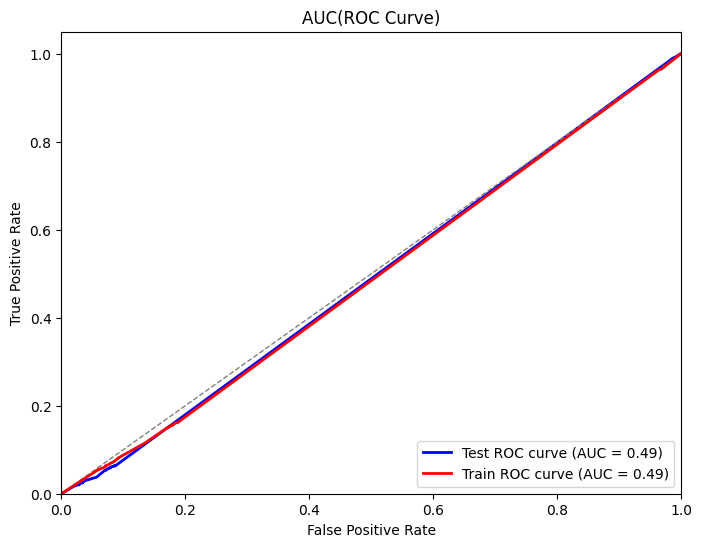

In [32]:
y_probs = svm.predict_proba(X_test)[:,1]
y_probs_train = svm.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
roc_auc = auc(fpr,tpr)
train_roc_auc = auc(train_fpr, train_tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='Test ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.plot(train_fpr, train_tpr, color='r', lw=2, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC(ROC Curve)')
plt.legend(loc='lower right')
plt.show()

### Decision Boundary

0.8212171052631579


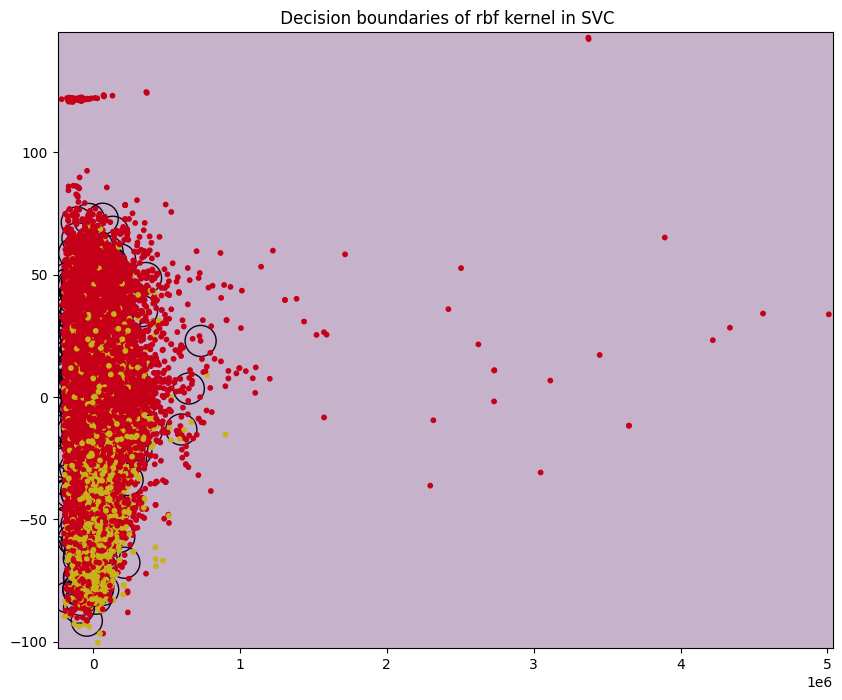

In [6]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    "C":[0.1],
    'gamma': [1],
    "kernel":["rbf"]
}

pca = decomposition.PCA(n_components=2)
X_red = pca.fit_transform(X_train)
X_red_te = pca.fit_transform(X_test)
svm = SVC(C=0.1, gamma=1, kernel="rbf")
svm.fit(pd.DataFrame(X_red).sample(1000), y_train.sample(1000))
print(accuracy_score(svm.predict(X_red_te), y_test))

_, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    svm.support_vectors_[:, 0],
    svm.support_vectors_[:, 1],
    s=500,
    facecolors="none",
    edgecolors="k",
)
#Plot samples by color and add legend
ax.scatter(X_red[:, 0], X_red[:, 1], c=y_train, s=10, cmap='autumn')
ax.set_title(f" Decision boundaries of rbf kernel in SVC")
DecisionBoundaryDisplay.from_estimator(
    svm,
    X_red,
    ax=ax,
    response_method='predict',
    alpha=0.3,
    plot_method='pcolormesh'
)
DecisionBoundaryDisplay.from_estimator(
    svm,
    X_red,
    ax=ax,
    response_method="decision_function",
    plot_method="contour",
    levels=[-1, 0, 1],
    colors=["k", "k", "k"],
    linestyles=["--", "-", "--"],
)

_ = plt.show()